# Includes:

In [70]:
%reload_ext autoreload
%autoreload 2
import seaborn as sn
import os
import matplotlib.pyplot as plt
from data_paths import get_file_paths_ordered
from pre_process import *
from models import *

from tensorflow import keras

In [115]:
MODEL_DIR = 'models/'
MODEL_NAME = 'labmodel.h5'
TFLITE_MODEL_NAME = 'tflite_'+ MODEL_NAME[:-3]
C_MODEL_NAME = MODEL_NAME[:-3]
print("Model names : ", MODEL_NAME,TFLITE_MODEL_NAME, C_MODEL_NAME)

NB_SPEAKERS = 5
dataset_percentage = 1 # 0.85
print("Number of speakers : ", NB_SPEAKERS)

Model names :  labmodel.h5 tflite_labmodel labmodel
Number of speakers :  5


Number of speakers and the percentage of the available samples to use to consider:

In [90]:
NB_SPEAKERS = 5
dataset_percentage = 1 # 0.85

Read data:

Total number of speakers in the original dataset: 5
Original number of files per speaker :  [1002, 656, 589, 570, 489]


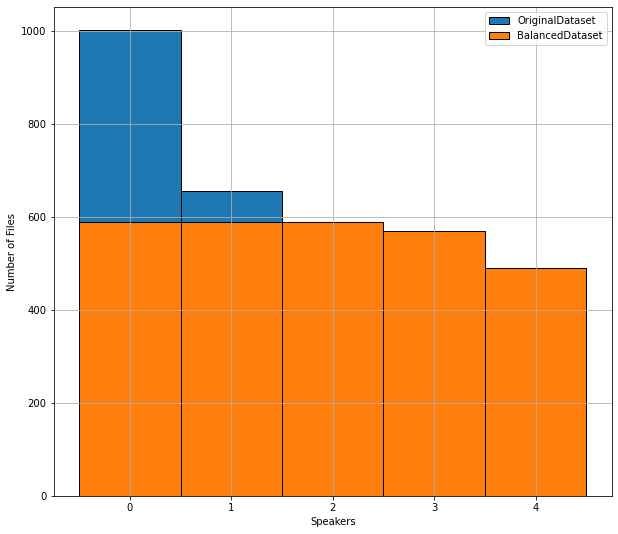

In [86]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l  = get_file_paths_ordered(num_speaker = NB_SPEAKERS, 
                                                                                    test_ratio = 0.2,
                                                                                    balanced_dataset = True, 
                                                                                    plot_data = True)

Visualization of the samples ...


100%|████████████████████████████████████████████████████████████████████████████| 2826/2826 [00:00<00:00, 5105.47it/s]


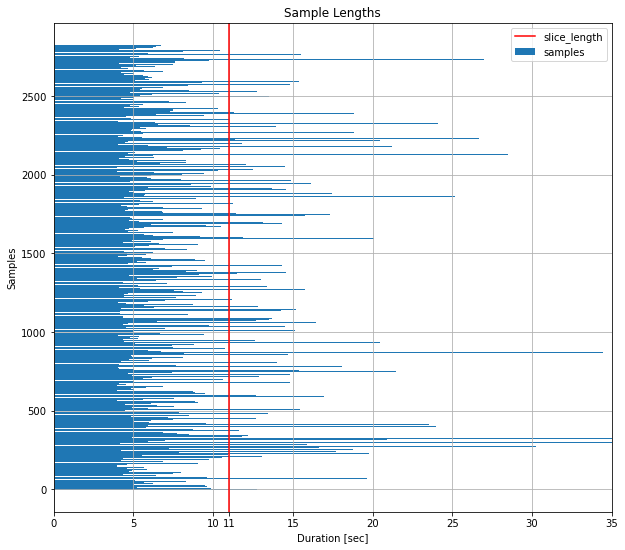

100%|██████████████████████████████████████████████████████████████████████████████| 566/566 [00:00<00:00, 1292.73it/s]


Train - test size :  (2260, 171, 1024) (566, 171, 1024)


In [112]:
seg_len = choose_tot_slice_len(paths=all_paths_l, visualize=True)

x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                    y_train_l=y_train_l, y_test_l=y_test_l,
                                                    tot_slice_len=seg_len,
                                                    used_train_sz_rat=dataset_percentage, 
                                                    used_test_sz_rat=dataset_percentage)

print("Train - test size : ", x_train.shape, x_test.shape)

# Pre-Processing:

In [95]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train.numpy(), y_train.numpy(), test_size=0.2)

In [98]:
x_train_mfcc = compute_mfccs(x_train)
x_val_mfcc = compute_mfccs(x_val)
x_test_mfcc  = compute_mfccs(x_test)
print("MFCC shape : ", x_train_mfcc.shape, x_val_mfcc.shape)

MFCC shape :  (1808, 171, 13, 1)


# Define the Model:

In [116]:
input_shape = x_train_mfcc.shape
model = get_model(input_shape=input_shape, nb_classes=NB_SPEAKERS, model_idx=0)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (2260, 171, 13, 1)       3         
 ion)                                                            
                                                                 
 conv2d_12 (Conv2D)          (2260, 171, 13, 3)        30        
                                                                 
 batch_normalization_12 (Bat  (2260, 171, 13, 3)       12        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (2260, 171, 13, 3)        0         
                                                                 
 conv2d_13 (Conv2D)          (2260, 86, 7, 16)         448       
                                                                 
 batch_normalization_13 (Bat  (2260, 86, 7, 16)       

Define learning parameters:

In [117]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 100 # nb of back propagations

Compile the model and Fit the Data:\
@TODO use weights giving the highest accuracy on the validation dataset

In [120]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

#o
callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_NAME + '_best.h5',save_best_only=True),
    #keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1.0e-5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),       
]
# es = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
# history = model.fit(x=x_train_mfcc, y=y_train, batch_size=batchSize, epochs=epochs, validation_split=0.2, callbacks=[es])
history = model.fit(
    x = x_train_mfcc, 
    y = y_train, 
    validation_split=0.2,
    callbacks = callbacks, 
    batch_size = batchSize, 
    epochs = epochs
)

Epoch 1/100
57/57 [==============================] - 3s 31ms/step - loss: 0.0095 - accuracy: 0.9978 - val_loss: 0.1858 - val_accuracy: 0.9381
Epoch 2/100
57/57 [==============================] - 2s 31ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.1209 - val_accuracy: 0.9646
Epoch 3/100
57/57 [==============================] - 2s 30ms/step - loss: 0.0126 - accuracy: 0.9950 - val_loss: 0.2236 - val_accuracy: 0.9425
Epoch 4/100
57/57 [==============================] - 2s 32ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.2274 - val_accuracy: 0.9403
Epoch 5/100
57/57 [==============================] - 2s 29ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.7557 - val_accuracy: 0.8628
Epoch 6/100
57/57 [==============================] - 2s 29ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.9735
Epoch 7/100
57/57 [==============================] - 2s 29ms/step - loss: 0.0041 - accuracy: 0.9994 - val_loss: 0.1105 - val_accuracy: 0.9646
Epoch 

Evaluate the performance on the test set:

In [121]:
y_pred = model.predict(x_test_mfcc)

test_loss, test_acc = model.evaluate(x_test_mfcc,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 0s 8ms/step
18/18 - 0s - loss: 0.1693 - accuracy: 0.9647 - 130ms/epoch - 7ms/step
Test accuracy: 0.9646643400192261
Test loss: 0.16934296488761902


In [101]:
y_pred = model.predict(x_test_mfcc)

test_loss, test_acc = model.evaluate(x_test_mfcc,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 0s 8ms/step
18/18 - 0s - loss: 0.1176 - accuracy: 0.9717 - 280ms/epoch - 16ms/step
Test accuracy: 0.971731424331665
Test loss: 0.11756837368011475


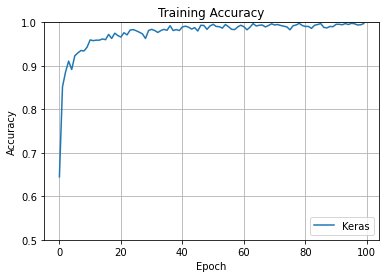

In [102]:
plt.plot(history_keras.history['accuracy'], label='Keras')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.grid()
plt.title("Training Accuracy")
plt.show()

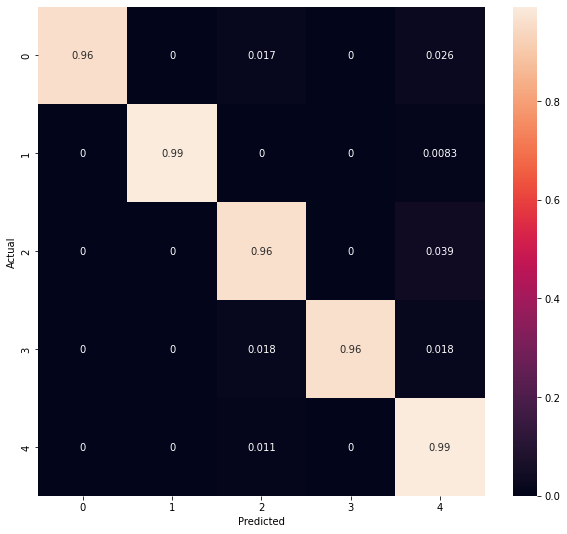

In [103]:
from sklearn.metrics import confusion_matrix

y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [104]:
model.save(MODEL_NAME)

Test image data location:  C:\Users\erolland\Documents\mcu\project\X_train.csv
Test labels location:  C:\Users\erolland\Documents\mcu\project\Y_train.csv


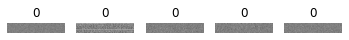

In [110]:
# save the train data as numpy arrays
np.save('X_train.csv', x_train.astype(np.uint8))
np.save('Y_train.csv', y_train)
# plot the first 5 images in the test set with their labels
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train.astype(np.uint8)[i], cmap='gray')
    plt.title(np.argmax(y_train[i]))
    plt.axis('off')

# print the location of the files
print('Test image data location: ', os.path.abspath('X_train.csv'))
print('Test labels location: ', os.path.abspath('Y_train.csv'))

In [105]:
# Show the model size for the non-quantized HDF5 model
h5_in_kb = os.path.getsize(MODEL_NAME) / 1024
print("HDF5 Model size without quantization: %d KB" % h5_in_kb)

HDF5 Model size without quantization: 326 KB


# TF Lite Conversion and Quantization:

In [17]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_NAME) 

In [36]:
train_set = x_train_mfcc
train_set.numpy().shape

(1017, 171, 13, 1)

In [47]:
def convert_to_tf_lite(train_set, model, tflite_model_name):
    train_set = train_set.numpy()
    # test_set = test_set.numpy()
    # train_labels = train_labels.numpy()
    # test_labels = test_labels.numpy()

    # Convert Keras model to a tflite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # Convert the model to the TensorFlow Lite format with quantization
    quantize = True
    if (quantize):
        def representative_dataset():
            for i in range(500):
                shape = train_set[i].shape[0]
                yield([train_set[i].reshape(1,shape,13,1)])

        # Set the optimization flag.
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

        # Enforce full-int8 quantization
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8  # or tf.uint8  quantization not compression 1/4
        converter.inference_output_type = tf.int8  # or tf.uint8
        # Provide a representative dataset to ensure we quantize correctly.
        
    converter.representative_dataset = representative_dataset
    tflite_model = converter.convert()

    open(tflite_model_name + '.tflite', 'wb').write(tflite_model)
    
    return tflite_model

In [48]:
tflite_model = convert_to_tf_lite(x_train_mfcc,model,TFLITE_MODEL_NAME)

INFO:tensorflow:Assets written to: C:\Users\erolland\AppData\Local\Temp\tmpxo3xms5z\assets


INFO:tensorflow:Assets written to: C:\Users\erolland\AppData\Local\Temp\tmpxo3xms5z\assets
C:\APPS\Anaconda3\envs\ml\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [50]:
# Show the model size for the non-quantized TFLite model
tflite_quant_in_kb = os.path.getsize(TFLITE_MODEL_NAME+'.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (h5_in_kb / tflite_quant_in_kb))

TFLite Model size without quantization: 28 KB

Reduction in model size by a factor of 11.667225


# C conversion

In [52]:
# Write TFLite model to a C source (or header) file
from c_code_conversion import *
with open(C_MODEL_NAME + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, C_MODEL_NAME))

In [ ]:
def save_array_to_file(x, y, x_file, y_file):
    np.save(x_file, x.astype(np.uint8))
    np.save(y_file, y)
    # plot the first 5 images in the test set with their labels
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(x.astype(np.uint8)[i], cmap='gray')
        plt.title(np.argmax(y[i]))
        plt.axis('off')

    # print the location of the files
    print('Test image data location: ', os.path.abspath(x_file))
    print('Test labels location: ', os.path.abspath(y_file))
    
save_array_to_file(X_test_q, y_test)

# Test the model

We can test the model using the tflite interpreter. We can use the set_tensor() function to set the input data and the invoke() function to run the model. We can then use the get_tensor() function to get the output data. More information can be found in the tflite interpreter documentation.

In [55]:
# Test the model using the tflite interpreter with quantization
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_NAME+'.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print some information about the input and output tensors
print("Input shape is {} and of type {}".format(input_details[0]['shape'], input_details[0]['dtype']))
print("Output shape is {} and of type {}".format(output_details[0]['shape'], output_details[0]['dtype']))
     

Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [1 5] and of type <class 'numpy.int8'>


In [56]:
# this may take a few minutes
input_data = X_test_q
input_shape = input_details[0]['shape']
interpreter.resize_tensor_input(input_details[0]['index'], input_data.shape)
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
     

NameError: name 'TBD' is not defined

In [ ]:
# plot the confusion matrix
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(TBD, TBD, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
     